In [21]:
#another example
import numpy as np
import pandas as pd
from rfgap import RFGAP
import seaborn as sns
import matplotlib.pyplot as plt
from rfphate import RFPHATE, dataprep

In [22]:
heart_disease = pd.read_csv("./datasets/heart_disease.csv")
# heart_disease.replace("?", np.nan, inplace=True)
# heart_disease.dropna(inplace=True)
heart_disease

,class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,0,63,1,1,145,233,1,2,150,0,2.3,3,0,6
1,2,67,1,4,160,286,0,2,108,1,1.5,2,3,3
2,1,67,1,4,120,229,0,2,129,1,2.6,2,2,7
3,0,37,1,3,130,250,0,0,187,0,3.5,3,0,3
4,0,41,0,2,130,204,0,2,172,0,1.4,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,1,45,1,1,110,264,0,0,132,0,1.2,2,0,7
299,2,68,1,4,144,193,1,0,141,0,3.4,2,2,7
300,3,57,1,4,130,131,0,0,115,1,1.2,2,1,7
301,1,57,0,2,130,236,0,2,174,0,0.0,2,1,3


In [23]:
x = heart_disease.iloc[:,1:-2]
y = heart_disease.iloc[:,0]

In [24]:
x

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,63,1,1,145,233,1,2,150,0,2.3,3
1,67,1,4,160,286,0,2,108,1,1.5,2
2,67,1,4,120,229,0,2,129,1,2.6,2
3,37,1,3,130,250,0,0,187,0,3.5,3
4,41,0,2,130,204,0,2,172,0,1.4,1
...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2
299,68,1,4,144,193,1,0,141,0,3.4,2
300,57,1,4,130,131,0,0,115,1,1.2,2
301,57,0,2,130,236,0,2,174,0,0.0,2


In [25]:
y

0      0
1      2
2      1
3      0
4      0
      ..
298    1
299    2
300    3
301    1
302    0
Name: class, Length: 303, dtype: int64

<Axes: xlabel='age', ylabel='trestbps'>

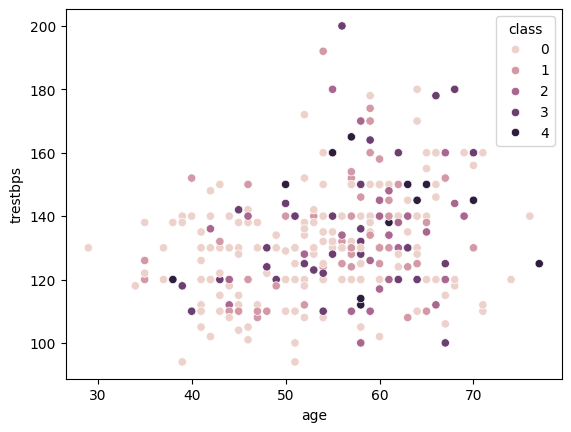

In [26]:
sns.scatterplot(x = x.iloc[:, 0], y = x.iloc[:, 3], hue = y)

In [27]:
print(heart_disease[heart_disease["class"] == 0].shape[0])
print(heart_disease[heart_disease["class"] == 1].shape[0])
print(heart_disease[heart_disease["class"] == 2].shape[0])
print(heart_disease[heart_disease["class"] == 3].shape[0])
print(heart_disease[heart_disease["class"] == 4].shape[0])

164
55
36
35
13


In [28]:
def rfOverSample(x, y, numSamples=3):

    #Train RF:
    rf = RFGAP(y = y, prediction_type = 'classification', matrix_type = 'dense')
    rf.fit(x, y)
    prox = rf.get_proximities()

    valueCounts = y.value_counts()
    majLabel = valueCounts.index[0]
    majCount = valueCounts.iloc[0]
    classCounts = valueCounts.to_dict()

    numFeatures = x.shape[1]

    for label in classCounts:
        if label != majLabel:
            upsampleSize = majCount - classCounts[label]
            newPoints = np.zeros((upsampleSize, numFeatures))

            for i in range(upsampleSize):
                sampleIndices = np.where(y == label)[0]
                samples = np.random.choice(sampleIndices, numSamples, replace=True)
                newFeatures = np.sum((np.matmul(np.transpose(x.iloc[samples,:]), prox[samples, :])), axis=1)/numSamples
                newPoints[i, : ] = newFeatures
                # print(type(newPoints))
            x = pd.concat((x, pd.DataFrame(newPoints, columns = x.columns))).reset_index(drop = True)
            y = pd.concat((y, pd.Series(np.ones_like(newPoints[ : , 0]) * label))).reset_index(drop = True)
    
    return x, y

In [29]:
x_upsampled, y_upsampled = rfOverSample(x, y)

In [30]:
print(y_upsampled[y_upsampled == 0].shape[0])
print(y_upsampled[y_upsampled == 1].shape[0])
print(y_upsampled[y_upsampled == 2].shape[0])
print(y_upsampled[y_upsampled == 3].shape[0])
print(y_upsampled[y_upsampled == 4].shape[0])

164
164
164
164
164


<Axes: xlabel='trestbps', ylabel='chol'>

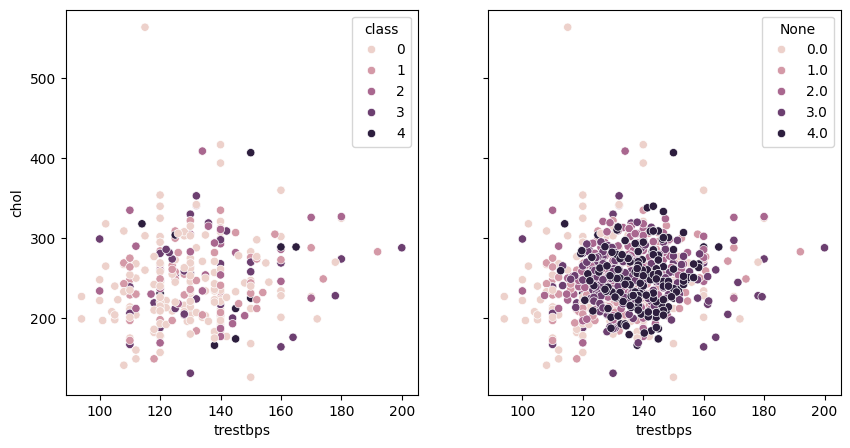

In [31]:
fig, ax = plt.subplots(1, 2,  figsize = (10, 5), sharey = True)

sns.scatterplot(x = x.iloc[:, 3], y = x.iloc[:, 4], hue = y, ax = ax[0])
sns.scatterplot(x = x_upsampled.iloc[:, 3], y = x_upsampled.iloc[:, 4], hue = y_upsampled, ax = ax[1])

In [32]:
y_upsampled.name = "class"
upsampled_heart_disease = pd.concat([x_upsampled, y_upsampled], axis = 1)
upsampled_heart_disease

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,class
0,63.000000,1.000000,1.000000,145.000000,233.000000,1.0,2.000000,150.000000,0.000000,2.300000,3.000000,0.0
1,67.000000,1.000000,4.000000,160.000000,286.000000,0.0,2.000000,108.000000,1.000000,1.500000,2.000000,2.0
2,67.000000,1.000000,4.000000,120.000000,229.000000,0.0,2.000000,129.000000,1.000000,2.600000,2.000000,1.0
3,37.000000,1.000000,3.000000,130.000000,250.000000,0.0,0.000000,187.000000,0.000000,3.500000,3.000000,0.0
4,41.000000,0.000000,2.000000,130.000000,204.000000,0.0,2.000000,172.000000,0.000000,1.400000,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
815,56.000000,1.000000,3.666667,130.666667,226.333333,0.0,2.000000,141.666667,0.333333,2.500000,2.000000,4.0
816,56.333333,1.000000,3.000000,134.333333,190.333333,0.0,0.666667,144.000000,1.000000,3.333333,2.333333,4.0
817,58.000000,1.000000,3.666667,136.666667,228.333333,0.0,2.000000,145.000000,0.666667,2.300000,2.000000,4.0
818,60.000000,1.000000,4.000000,141.666667,207.666667,0.0,1.333333,128.333333,0.666667,2.533333,2.333333,4.0


In [33]:
# sns.PairGrid(x_upsampled)

In [48]:
heart_disease

,class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,0,63,1,1,145,233,1,2,150,0,2.3,3,0,6
1,2,67,1,4,160,286,0,2,108,1,1.5,2,3,3
2,1,67,1,4,120,229,0,2,129,1,2.6,2,2,7
3,0,37,1,3,130,250,0,0,187,0,3.5,3,0,3
4,0,41,0,2,130,204,0,2,172,0,1.4,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,1,45,1,1,110,264,0,0,132,0,1.2,2,0,7
299,2,68,1,4,144,193,1,0,141,0,3.4,2,2,7
300,3,57,1,4,130,131,0,0,115,1,1.2,2,1,7
301,1,57,0,2,130,236,0,2,174,0,0.0,2,1,3


In [49]:
upsampled_heart_disease

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,class
0,63.000000,1.000000,1.000000,145.000000,233.000000,1.0,2.000000,150.000000,0.000000,2.300000,3.000000,0.0
1,67.000000,1.000000,4.000000,160.000000,286.000000,0.0,2.000000,108.000000,1.000000,1.500000,2.000000,2.0
2,67.000000,1.000000,4.000000,120.000000,229.000000,0.0,2.000000,129.000000,1.000000,2.600000,2.000000,1.0
3,37.000000,1.000000,3.000000,130.000000,250.000000,0.0,0.000000,187.000000,0.000000,3.500000,3.000000,0.0
4,41.000000,0.000000,2.000000,130.000000,204.000000,0.0,2.000000,172.000000,0.000000,1.400000,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
815,56.000000,1.000000,3.666667,130.666667,226.333333,0.0,2.000000,141.666667,0.333333,2.500000,2.000000,4.0
816,56.333333,1.000000,3.000000,134.333333,190.333333,0.0,0.666667,144.000000,1.000000,3.333333,2.333333,4.0
817,58.000000,1.000000,3.666667,136.666667,228.333333,0.0,2.000000,145.000000,0.666667,2.300000,2.000000,4.0
818,60.000000,1.000000,4.000000,141.666667,207.666667,0.0,1.333333,128.333333,0.666667,2.533333,2.333333,4.0


In [43]:
x_phate_upsampled, y_phate_upsampled = dataprep(upsampled_heart_disease, label_col_idx=11)
x_phate, y_phate = dataprep(heart_disease, label_col_idx=0)


In [44]:
embedding_upsampled = rfphate.fit_transform(x_phate_upsampled, y_phate_upsampled)
embedding = rfphate.fit_transform(x_phate, y_phate)


<Axes: >

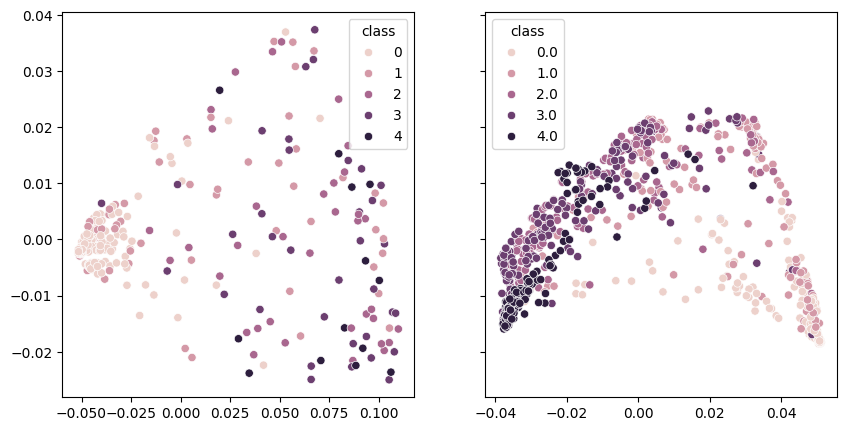

In [45]:
fig, ax = plt.subplots(1, 2,  figsize = (10, 5), sharey = True)

sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=y_phate, ax=ax[0])
sns.scatterplot(x=embedding_upsampled[:, 0], y=embedding_upsampled[:, 1], hue=y_phate_upsampled, ax=ax[1])

In [ ]:

#make the columns of heart_disease and upsampled_heart_disease in the same order. This involves getting rid of "ca" and "thal" columns in heart_disease, and moving "class" to the front in upsampled_heart_disease


